## Полезные ссылки и литература

#### Этот блокнот основан на посте:
https://github.com/msurtsukov/ae_vae_gan/blob/master/cVAE.ipynb  
Можно сказать что это репост кода + некая творческай постобработка под обновленный keras + tf.

https://keras.io/examples/generative/vae/


#### Литература и ссылки из поста:
Теоретическая часть основана на статье:  
[1] Tutorial on Variational Autoencoders, Carl Doersch, https://arxiv.org/abs/1606.05908  
и фактически является ее кратким изложением

Многие картинки взяты из блога Isaac Dykeman:  
[2] Isaac Dykeman, http://ijdykeman.github.io/ml/2016/12/21/cvae.html  

Подробнее прочитать про расстояние Кульбака-Лейблера на русском можно в   
[3] http://www.machinelearning.ru/wiki/images/d/d0/BMMO11_6.pdf  

Код частично основан на статье *Francois Chollet*:  
[4] https://blog.keras.io/building-autoencoders-in-keras.html  

Другие интересные ссылки:  
http://blog.fastforwardlabs.com/2016/08/12/introducing-variational-autoencoders-in-prose-and.html  
http://kvfrans.com/variational-autoencoders-explained/  


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import datetime
import copy
from typing import Optional, Tuple, List, Union
import numpy as np
import pandas as pd
import io

from IPython.display import clear_output, display, HTML

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import animation

import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense, Layer, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


from data.get_data import get_mnist
from visualization.plot_graph import (
    plot_digits, 
    sapmpling_2d_normal_grid, 
    plot_2d_latent_space_grid,
    draw_manifold_cvae,
    combine_two_figures_horisontally,
    create_animation_from_array_of_figures,
    convert_figures_to_array,
)

%matplotlib inline

animation.writers.list()

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']

# Часть 4: Conditional VAE

## Теория

В прошлой части мы познакомились с ***вариационными автоэнкодерами (VAE)***, реализовали такой на *keras*, а так же поняли, как с его помощью генерировать изображения. Получившаяся модель, однако, обладала некоторыми недостатками:
1. Не все цифры получилось хорошо закодировать в скрытом пространстве: некоторые цифры либо, вообще остсутствовали, либо были очень смазанными. В промежутках между областями, в которых были сконцентрированы варианты одной и той же цифры, находились вообще какие-то быссмысленные иероглифы.  
    Что тут писать, вот так выглядели сгенерированные цифры:  
<img src="./pics/04_manifold_vae_example.png" width="400"/>  
2. Сложно было генерировать картинку какой-то заданной цифры. Для этого надо было смотреть, в какую область латентного пространства попадали изображения конкретной цифры, и сэмплить уже откуда-то оттуда, а тем более было сложно генерировать цифру в каком-то заданном стиле.

В этой части мы посмотрим как можно лишь очень слегка усложнив модель преодолеть обе эти проблемы, и заодно получим возможность генерировать картинки новых цифр в стиле другой цифры - это наверное самая интересная фича будущей модели. 

### Сначала подумаем о причинах 1-го недостатка:  
Многообразия на которых лежат различные цифры могут быть далеко друг от друга в пространстве картинок. То есть сложно представить, как например непрерывно отобразить картинку цифры '5', в картинку цифры '7', при том, чтобы все промежуточные картинки можно было назвать правдоподобными. Таким образом, многообразие, около которого лежат цифры, вовсе не обязано быть линейно связным. Автоэнкодер же, в силу того что является композицией непрерывных функций, сам может отображать в код и обратно только непрерывно, особенно если это вариационный автоэнкодер. В нашем предыдущем примере все усложнялось еще и тем, что, автоэнкодер пытался искать двумерное многообразие.  
В качестве иллюстрации вернемся к нашему искусственному примеру из 2-ой части, только сделаем определяющее многообразие несвязным:

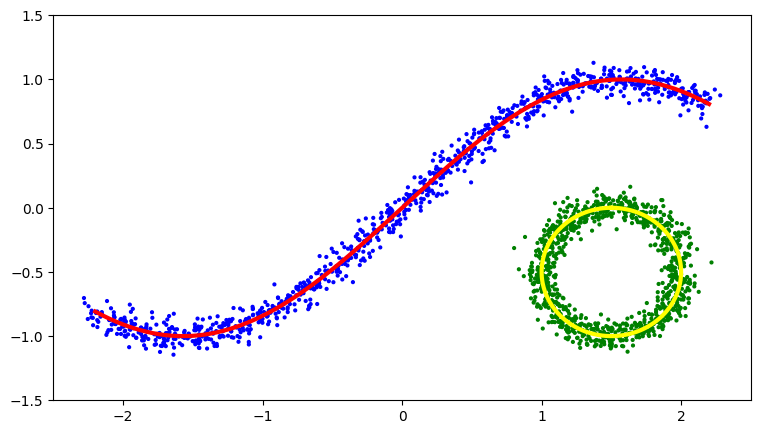

In [26]:
# Создание датасета
x1 = np.linspace(-2.2, 2.2, 1000)
fx = np.sin(x1)
dots1 = np.vstack([x1, fx]).T

t = np.linspace(0, 2*np.pi, num=1000)
dots2 = 0.5*np.array([np.sin(t), np.cos(t)]).T + np.array([1.5, -0.5])[None, :]

dots = np.vstack([dots1, dots2])
noise = 0.06 * np.random.randn(*dots.shape)

labels = np.array([0]*1000 + [1]*1000)
noised = dots + noise


# Визуализация
colors = ["b"]*1000 + ["g"]*1000
plt.figure(figsize=(9, 5))
plt.xlim([-2.5, 2.5])
plt.ylim([-1.5, 1.5])
plt.scatter(noised[:, 0], noised[:, 1], c=colors, s=4)
plt.plot(dots1[:, 0], dots1[:, 1],  color="red",    linewidth=3)
plt.plot(dots2[:, 0], dots2[:, 1],  color="yellow", linewidth=3)
plt.grid(False)

Здесь:
* синие и зеленые точки - объекты выборки,
* красная и желтая кривые - несвязанное определяющее многообразие.

Попробуем теперь выучить определяющее многообразие с помощью обычного глубокого автоэнкодера.

![](pics/04_deep_ae.png)

In [27]:
def deep_ae():
    input_dots = Input((2,))
    x = Dense(64, activation="elu")(input_dots)
    x = Dense(64, activation="elu")(x)
    code = Dense(1, activation="linear")(x)
    x = Dense(64, activation="elu")(code)
    x = Dense(64, activation="elu")(x)
    out = Dense(2, activation="linear")(x)

    ae = Model(input_dots, out)
    return ae

dae = deep_ae()

# # Save for Netron visualisation
# dae.save("../models/04_deep_ae_model.h5", save_format="h5")

dae.compile(Adam(0.001), "mse")
dae.fit(noised, noised, epochs=300, batch_size=30, verbose=0)

# Результат
predicted = dae.predict(noised)

63/63 [==============================] - 0s 3ms/step


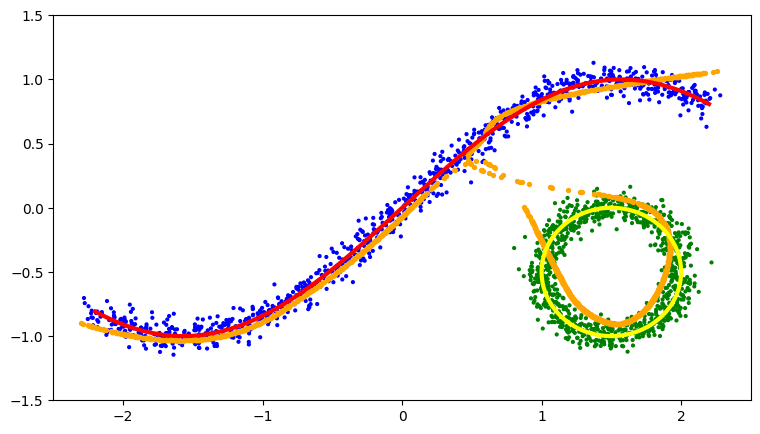

In [28]:
# Визуализация
plt.figure(figsize=(9, 5))
plt.xlim([-2.5, 2.5])
plt.ylim([-1.5, 1.5])
plt.scatter(noised[:, 0], noised[:, 1], c=colors, s=4)
plt.plot(dots1[:, 0], dots1[:, 1],  color="red",    linewidth=3)
plt.plot(dots2[:, 0], dots2[:, 1],  color="yellow", linewidth=3)
plt.scatter(predicted[:, 0], predicted[:, 1], c="orange", s=8)
plt.grid(False)

* оранжевая линия - многообразие в которое переходят синие и зеленые точки данных после автоэнкодера,
то есть попытка автоэнкодера построить многообразие, определяющее больше всего вариации в данных

Видно, что у простого автоэнкодера не получилось выучить форму несвязного многообразия. Вместо этого, он хитро продолжил одно в другое.

Если же мы знаем лейблы данных, которые определяют на каком из частей несвязного многообразия лежат данные (как с цифрами), то мы можем просто *condition* автоэнкодер на этих лейблах. То есть просто дополнительно с данными, подавать на вход энкодеру и декодеру еще и лейблы данных. В таком случае источником разрывности в данных будет лейбл и это позволит автоэнкодеру выучить каждую часть линейно несвязного многообразия отдельно.

Посмотрим на тот же самый пример, только теперь на вход и энкодеру, и декодеру будем передавать дополнительно еще и лейбл.


![](pics/04_deep_cond_ae.png)

In [29]:
def deep_cond_ae():
    input_dots = Input((2,))
    input_lbls = Input((1,))
    full_input = concatenate([input_dots, input_lbls])
    x = Dense(64, activation="elu")(full_input)
    x = Dense(64, activation="elu")(x)
    code = Dense(1, activation="linear")(x)

    full_code = concatenate([code, input_lbls])
    x = Dense(64, activation="elu")(full_code)
    x = Dense(64, activation="elu")(x)
    out = Dense(2, activation="linear")(x)

    ae = Model([input_dots, input_lbls], out)
    return ae


cdae = deep_cond_ae()

# # Save for Netron visualisation
# cdae.save("../models/04_deep_cond_ae_model.h5", save_format="h5")

cdae.compile(Adam(0.001), "mse")
cdae.fit([noised, labels], noised, epochs=300, batch_size=30, verbose=0)

predicted = cdae.predict([noised, labels])

63/63 [==============================] - 0s 2ms/step


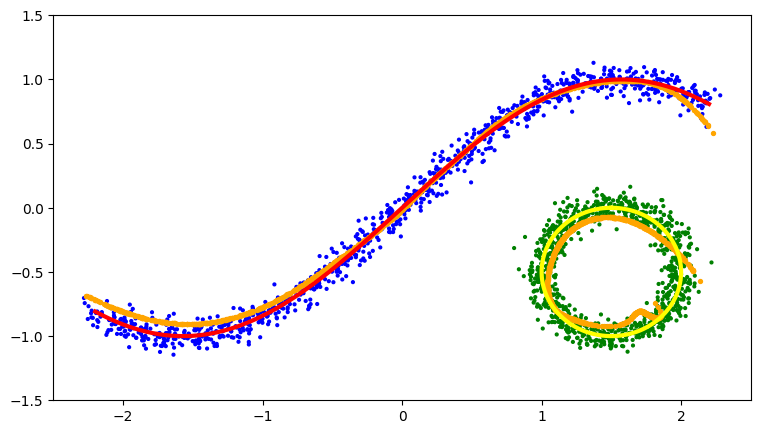

In [30]:
# Визуализация
plt.figure(figsize=(9, 5))
plt.xlim([-2.5, 2.5])
plt.ylim([-1.5, 1.5])
plt.scatter(noised[:, 0], noised[:, 1], c=colors, s=4)
plt.plot(dots1[:, 0], dots1[:, 1],  color="red",    linewidth=3)
plt.plot(dots2[:, 0], dots2[:, 1],  color="yellow", linewidth=3)
plt.scatter(predicted[:, 0], predicted[:, 1], c="orange", s=8)
plt.grid(False)

На этот раз автоэнкодеру удалось выучить линейно несвязное определяющее многообразие.

## CVAE

Если же теперь взять *VAE* как в предыдущей части, и подавать на вход еще и лейблы, то получится ***Conditional Variational Autoencoder (CVAE)***. 

С картинками цифр получается вот так:

![](./pics/04_cvae_diagram.png)

Картинка выше из ***[2]***

При этом основное уравнение *VAE* из прошлой части, становится просто *conditioned* на $Y$ ($Y$ при этом не обязан быть дискретным), то есть на лейбле.

$$
\log P(X|Y;\theta_2) - KL[Q(Z|X,Y;\theta_1)||P(Z|X,Y;\theta_2)] = E_{Z \sim Q}[\log P(X|Z,Y;\theta_2)] - KL[Q(Z|X,Y;\theta_1)||N(0,I)]
$$

$Q(Z|X,Y;\theta_1)$ при этом мы опять сравниваем с $N(0,I)$, вынуждая автоэнкодер искать $Z$ независимо от $Y$. 

*CVAE* кодирует в $Z$ свойства входного сигнала общие для всех $Y$.

## Перенос стиля


(Комментарий: это не тоже самое, что перенос стиля в Prisme, там совсем другое)

Теперь становится понятно, как создавать новые картинки в стиле заданной:
1. обучаем *CVAE* на картинках с лейблами,
2. кодируем стиль заданной картинки в $Z$,
3. меняя лейблы $Y$ создаем из закодированного $Z$ новые картинки

## Код на *Keras*

Код практически идентичен коду из предыдущей части, за исключением, того что теперь в энкодер и декодер передается и лейбл цифры.

*(Оставил только dense, без сверточных сетей)*

In [9]:
x_train, y_train, x_test, y_test = get_mnist()

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)
num_classes = y_test_cat.shape[1]

# print(x_train.nbytes)


In [10]:
# Необходимые функции и классы для задания для вариационных автоенкодеров

# ========================================================
# Добавление Dropout и BatchNormalization между слоями
def apply_bn_and_dropout(x, dropout_rate: float):
    return Dropout(dropout_rate)(BatchNormalization()(x))


# ========================================================
# Энкодер Dense ==========================================
def create_dense_encoder(latent_dim: int, dropout_rate: float):
    input_img = Input(shape=(28, 28, 1), name="enc_input")
    flatten_img = Flatten(name="enc_flatten")(input_img)
    input_lbl = Input(shape=(num_classes,), dtype='float32', name="label_input")

    x = concatenate([flatten_img, input_lbl])
    x = Dense(256, activation="relu", name="enc_dense_1")(x)
    x = apply_bn_and_dropout(x, dropout_rate)
    x = Dense(128, activation="relu", name="enc_dense_2")(x)
    x = apply_bn_and_dropout(x, dropout_rate)

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение,
    # предсказываем логарифм вариации
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    # --------------------------------------------------------
    # Сэмплирование из Q с трюком репараметризации
    # делается через кастомный слой
    class SamplingLayer(Layer):
        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0)
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = SamplingLayer()([z_mean, z_log_var])

    model_encoder = Model([input_img, input_lbl], [z_mean, z_log_var, z], name="Dense_Encoder")
    return model_encoder


# ========================================================
# Декодер Dense ==========================================
def create_dense_decoder(latent_dim: int, dropout_rate: float):
    latent_inputs = Input(shape=(latent_dim,), name="dec_input")
    input_lbl_d = Input(shape=(num_classes,), dtype='float32', name="label_input")
    x = concatenate([latent_inputs, input_lbl_d])
    # x = Dense(128, activation='relu', name="dec_dense_1")(z)
    x = Dense(128, name="dec_dense_1")(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x, dropout_rate)
    # x = Dense(256, activation='relu', name="dec_dense_2")(x)
    x = Dense(256, name="dec_dense_2")(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x, dropout_rate)
    x = Dense(28 * 28, activation="sigmoid", name="dec_results")(x)
    decoded = Reshape((28, 28, 1))(x)

    model_decoder = Model([latent_inputs, input_lbl_d], decoded, name="Dense_Decoder")
    return model_decoder


# ========================================================
# Батч-нормализация перенесена перед функцие активации
# 1) Dense layer without activation
# 2) Batch normalization layer
# 3) Activation layer
# 4) Dropout layer
# Добавлена регуляризация на веса сети (weigth-decay)

# ========================================================
# Энкодер Dense 2 =========================================
def create_dense_encoder_2(latent_dim: int, dropout_rate: float):
    input_img = Input(shape=(28, 28, 1), name="enc_input")
    flatten_img = Flatten(name="enc_flatten")(input_img)
    input_lbl = Input(shape=(num_classes,), dtype='float32', name="label_input")

    x = concatenate([flatten_img, input_lbl])
    x = Dense(256, name="enc_dense_1")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, name="enc_dense_2")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x)

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение,
    # предсказываем логарифм вариации
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    # --------------------------------------------------------
    # Сэмплирование из Q с трюком репараметризации
    # делается через кастомный слой
    class SamplingLayer(Layer):
        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0)
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = SamplingLayer()([z_mean, z_log_var])

    model_encoder = Model([input_img, input_lbl], [z_mean, z_log_var, z], name="Dense_Encoder")
    return model_encoder

# Декодер Dense 2 =========================================
def create_dense_decoder_2(latent_dim: int, dropout_rate: float):
    latent_inputs = Input(shape=(latent_dim,), name="dec_input")
    input_lbl_d = Input(shape=(num_classes,), dtype='float32', name="label_input")
    x = concatenate([latent_inputs, input_lbl_d])
    # x = Dense(128, activation='relu', name="dec_dense_1")(z)
    x = Dense(128, name="dec_dense_1")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)
    # x = Dense(256, activation='relu', name="dec_dense_2")(x)
    x = Dense(256, name="dec_dense_2")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(28 * 28, activation="sigmoid", name="dec_results")(x)
    decoded = Reshape((28, 28, 1))(x)

    model_decoder = Model([latent_inputs, input_lbl_d], decoded, name="Dense_Decoder")
    return model_decoder


# ========================================================
# Модель cVAE создается как класс    ======================
# с кастомным train_step (vae-loss) ======================
class CVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def __custom_loss_function(self, x, y_true):
        input_img, input_lbl, input_lbl_d = x
        # Forward pass
        z_mean, z_log_var, z = self.encoder([input_img, input_lbl])
        reconstruction = self.decoder([z, input_lbl_d])
        # Compute loss
        reconstruction_loss = tf.reduce_sum(
            keras.losses.binary_crossentropy(y_true, reconstruction), axis=(1, 2)
        )
        reconstruction_loss = (
            reconstruction_loss / 28 / 28
        )  # reconstruction_loss per pixel
        reconstruction_loss_mean = tf.reduce_mean(reconstruction_loss)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_sum(kl_loss, axis=1)
        kl_loss = kl_loss / 28 / 28  # kl_loss per pixel
        kl_loss_mean = tf.reduce_mean(kl_loss)

        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        return reconstruction_loss, kl_loss, total_loss

    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to 'fit()'
        x, y = data
        with tf.GradientTape() as tape:
            reconstruction_loss, kl_loss, total_loss = self.__custom_loss_function(x, y)

        # Compute gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Update weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        # Return a dict mapping metric names to current value
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to 'fit()'
        x, y = data
        reconstruction_loss, kl_loss, total_loss = self.__custom_loss_function(x, y)
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        # Return a dict mapping metric names to current value
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs, training=None, mask=None):
        input_img, input_lbl, input_lbl_d = inputs
        # Forward pass
        z_mean, z_log_var, z = self.encoder([input_img, input_lbl])
        reconstruction = self.decoder([z, input_lbl_d])
        return reconstruction

In [11]:
# learning and create figures

def fit_and_collect_learning_history(
    cvae_nn: CVAE,
    num_classes: int,
    max_epochs: int,
    batch_size: int = 256
) -> Tuple[
    List[mpl.figure.Figure],
    List[mpl.figure.Figure],
    List[np.array],
    List[int],
    pd.DataFrame,
]:
    """Fits the CVAE model to training data and collects learning history for visualization.

    Parameters
    ----------
    vae_nn : VAE
        The VAE model to be trained and monitored.
    num_classes: int
        Number of classes in CVAE.
    max_epochs : int
        Maximum number of epochs for training.
    batch_size: int
        The batch size for training (default: 256).

    Returns
    -------
    tuple :
        A tuple containing
            manifold_figs - A list of `matplotlib` figures for the manifold of generated images.
            latent_distrs - A list of `matplotlib` figures for the latent space distribution of test images.
            sample_imgs - A list of np.array for the comparison of real and decoded images from the test set.
            epochs - A list for the epochs.
            vae_train_results_pdf - A pandas DataFrame containing the training history with epochs as index.

    Notes
    -----
    This function fits the `vae_nn` model to training data and collects various data for visualization:
        - Comparison of real and decoded images from the test set
        - Latent space distribution of test images
        - Manifold of generated images

    The `on_epoch_end` callback is defined inside this function and is triggered after each epoch.
    It updates the arrays `manifold_figs`, `latent_distrs`, `sample_imgs`, and `epochs` with the corresponding results
    for visualization purposes.

    The collected data can be used to create animations of the learning process.
    """
    # Массивы в которые будем сохранять результаты,
    # для последующей визуализации
    manifold_figs = [[] for x in range(num_classes)]
    latent_distrs = [[] for x in range(num_classes)]
    sample_imgs = []
    epochs = []

    # Эпохи в которые будем сохранять
    # Первые 10 подряд, потом с увеличиающимся интервалом
    save_epochs = set(
        list((np.arange(0, 300) ** 1.701).astype(np.int64)) + list(range(10))
    )

    # Отслеживать будем на вот этих цифрах
    imgs = x_test[:batch_size]
    imgs_lbls = y_test_cat[:batch_size]
    n_compare = 10  # Сколько первых цифр из теста мониторим
    n_count = 15  # Картинка с 15x15 цифр для многообразия

    # Фунция, которую будем запускать после каждой эпохи
    def on_epoch_end(epoch, logs):
        if epoch in save_epochs:
            clear_output()  # Не захламляем output

            # Текущая эпоха
            epochs.append(epoch)

            # Сравнение реальных и декодированных цифр
            decoded = cvae_nn.predict(
                [imgs, imgs_lbls, imgs_lbls], batch_size=batch_size
            )
            sample_imgs.append(decoded[:n_compare])

            # Рисование многообразия и диаграммы рассеяния
            grid_x, grid_y = sapmpling_2d_normal_grid(n_count)

            for lbl in range(num_classes):
                idxs = y_test == lbl
                z_mean, z_log_var, x_test_encoded = cvae_nn.encoder.predict(
                    [x_test[idxs], y_test_cat[idxs]], batch_size=batch_size, verbose=0
                )
                generator = cvae_nn.decoder

                latentspace_fig = plot_2d_latent_space_grid(
                    x_test[idxs],
                    y_test[idxs],
                    x_test_encoded,
                    False,
                    False,
                    True,
                    grid_x,
                    grid_y,
                    False,
                )
                manifold_fig = draw_manifold_cvae(
                    generator, lbl, grid_x, grid_y, show=False
                )

                # Сохранение многообразия и диаграмму рассеяния
                # для создания анимации после
                manifold_figs[lbl].append(manifold_fig)
                latent_distrs[lbl].append(latentspace_fig)

    # callbacks ----------------------------------------------------
    pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

    # Train --------------------------------------------------------
    cvae_train_results = cvae_nn.fit(
        [x_train, y_train_cat, y_train_cat],
        x_train,
        shuffle=True,
        validation_data=([x_test, y_test_cat, y_test_cat], x_test),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[pltfig],
        verbose=0,
    )

    cvae_train_results_pdf = pd.DataFrame(
        cvae_train_results.history, index=cvae_train_results.epoch
    )

    return manifold_figs, latent_distrs, sample_imgs, epochs, cvae_train_results_pdf


# # Create animations of results
# def create_animations(
#     name: str,
#     manifold_figs_list: List[mpl.figure.Figure],
#     latent_distrs_list: List[mpl.figure.Figure],
#     sample_imgs_list: List[np.array],
#     epochs_list: List[int],
#     imgs: List[np.array],
# ) -> None:
#     """Create animations from the list of figures, latent distributions and sample images.

#     Parameters
#     ----------
#     name : str
#         The name for the animations.
#     manifold_figs_list : List[mpl.figure.Figure]
#         A list of matplotlib figures that represent the manifold.
#     latent_distrs_list : List[mpl.figure.Figure]
#         A list of matplotlib figures that represent the latent distributions.
#     sample_imgs_list : List[np.array]
#         A list of numpy arrays that represent the sample images.
#     epochs_list : List[int]
#         A list of integers that represent the epochs.
#     imgs: List[np.array]
#         A list of numpy array that represents true values of compared images

#     Returns
#     -------
#     None
#     """

#     titles_list = [f"Epoch: {e}" for e in epochs_list]

#     # manifold_figs
#     _ = create_animation_from_array_of_figures(
#         manifold_figs_list,
#         titles_list,
#         figsize=(6, 6),
#         filename=f"./anim/03_{name}_manifold.mp4",
#     )

#     # latent_distrs
#     _ = create_animation_from_array_of_figures(
#         latent_distrs_list,
#         titles_list,
#         figsize=(7, 5),
#         filename=f"./anim/03_{name}_latent_distrs.mp4",
#     )

#     # compare images
#     dense_vae_sample_imgs_list = [
#         plot_digits(imgs[:10], sample_img[:10], show=False)
#         for sample_img in sample_imgs_list
#     ]
#     _ = create_animation_from_array_of_figures(
#         dense_vae_sample_imgs_list,
#         titles_list,
#         figsize=(8, 2),
#         filename=f"./anim/03_{name}_sample_imgs.mp4",
#     )

#     # combined latent space and manifold
#     figsize = (10, 5)
#     dense_vae_combined_fig_list = [
#         combine_two_figures_horisontally(
#             latentspace_fig, manifold_fig, figsize=figsize, show=False
#         )
#         for latentspace_fig, manifold_fig in zip(latent_distrs_list, manifold_figs_list)
#     ]

#     _ = create_animation_from_array_of_figures(
#         dense_vae_combined_fig_list,
#         titles_list,
#         figsize=figsize,
#         filename=f"./anim/03_{name}_combined.mp4",
#     )

In [12]:
batch_size = 256
latent_dim = 2
dropout_rate = 0.3
start_lr = 0.001
max_epochs = 200

### Dense CVAE (latent dim 2)

**Общая схема** - аналогична стандартному автоэнкодеру  

Вся прелесть именно в энкодере и декодере  
**Encoder**  
![](pics/04_cvae_dense_encoder.png)

**Decoder**  
![](pics/04_cvae_dense_decoder.png)  


In [13]:
%%time

# DENSE_CVAE =====================================================
dense_encoder = create_dense_encoder(latent_dim, dropout_rate)
dense_decoder = create_dense_decoder(latent_dim, dropout_rate)

dense_cvae = CVAE(dense_encoder, dense_decoder, name="CVAE")
dense_cvae.compile(optimizer=Adam(start_lr), run_eagerly=False)

dense_cvae.build(input_shape=[(None, 28, 28, 1), (None, 10), (None, 10)])
# print(dense_cvae.summary())

# # Save for Netron visualisation
# dense_cvae.encoder.save("../models/04_cvae_dense_encoder_model.h5", save_format="h5")
# dense_cvae.decoder.save("../models/04_cvae_dense_decoder_model.h5", save_format="h5")

# learning -------------------------------------------------------
(
    dense_cvae_manifold_figs,
    dense_cvae_latent_distrs,
    dense_cvae_sample_imgs,
    dense_cvae_epochs,
    dense_cvae_train_results_pdf,
) = fit_and_collect_learning_history(
    dense_cvae, num_classes=num_classes, max_epochs=max_epochs, batch_size=batch_size
)

# Save weights -----------------------------------------------------
dense_cvae.save_weights("../models/04_dense_cvae_weights.h5")
# # after recreate object. Can continue fitting or using model
# dense_cvae.load_weights("../models/04_dense_cvae_weights.h5") 

# 1000 epoch - 180 min

1/1 [==============================] - 0s 154ms/step


In [ ]:
print(dense_cvae.summary())

Model: "CVAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_Encoder (Functional)  [(None, 2),               238468    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 Dense_Decoder (Functional)  (None, 28, 28, 1)         237712    
                                                                 
Total params: 476,186
Trainable params: 474,644
Non-trainable params: 1,542
_________________________________________________________________
None


In [ ]:
print ("losses:" + "="*53)
print("dense_cvae:\n", dense_cvae_train_results_pdf.tail(1).to_string(index=False, header=True, line_width=None))

losses:=====================================================
dense_cvae:
     loss  reconstruction_loss  kl_loss  val_loss  val_reconstruction_loss  val_kl_loss
0.153076             0.145563 0.007498  0.167049                 0.159761     0.007359


<AxesSubplot:>

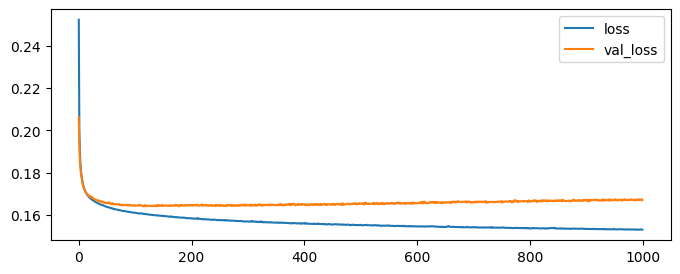

In [ ]:
dense_cvae_train_results_pdf[["kl_loss","val_kl_loss"]].plot(figsize=(8,3), logx=True)
dense_cvae_train_results_pdf[["loss","val_loss"]].plot(figsize=(8,3), logx=True)

### Dense CVAE 2 (latent dim 2)

Батч-нормализация перенесена перед функцией активации, это более рекомендованный вариант.
1) Dense layer without activation
2) Batch normalization layer
3) Activation layer
4) Dropout layer

**Общая схема** - аналогична стандартному автоэнкодеру  

Вся прелесть именно в энкодере и декодере  
**Encoder**  
![](pics/04_cvae_dense2_encoder.png)

**Decoder**  
![](pics/04_cvae_dense2_decoder.png)  

In [ ]:
%%time

# DENSE_CVAE =====================================================
dense_encoder_2 = create_dense_encoder_2(latent_dim, dropout_rate)
dense_decoder_2 = create_dense_decoder_2(latent_dim, dropout_rate)

dense2_cvae = CVAE(dense_encoder_2, dense_decoder_2, name="CVAE")
dense2_cvae.compile(optimizer=Adam(start_lr), run_eagerly=False)

dense2_cvae.build(input_shape=[(None, 28, 28, 1), (None, 10), (None, 10)])
# print(dense_cvae.summary())

# # Save for Netron visualisation
# dense2_cvae.encoder.save("../models/04_cvae_dense2_encoder_model.h5", save_format="h5")
# dense2_cvae.decoder.save("../models/04_cvae_dense2_decoder_model.h5", save_format="h5")

# learning -------------------------------------------------------
(
    dense2_cvae_manifold_figs,
    dense2_cvae_latent_distrs,
    dense2_cvae_sample_imgs,
    dense2_cvae_epochs,
    dense2_cvae_train_results_pdf,
) = fit_and_collect_learning_history(
    dense2_cvae, num_classes=num_classes, max_epochs=max_epochs, batch_size=batch_size
)

# Save weights -----------------------------------------------------
dense2_cvae.save_weights("../models/04_dense2_cvae_weights.h5")
# # after recreate object. Can continue fitting or using model
# dense2_cvae.load_weights("../models/04_dense2_cvae_weights.h5") 

# 3000 epoch -  5h 7min


1/1 [==============================] - 0s 20ms/step


CPU times: total: 6h 33min 19s
Wall time: 5h 7min 25s


In [ ]:
print ("losses:" + "="*53)
print("dense2_cvae:\n", dense2_cvae_train_results_pdf.tail(1).to_string(index=False, header=True, line_width=None))

losses:=====================================================
dense2_cvae:
     loss  reconstruction_loss  kl_loss  val_loss  val_reconstruction_loss  val_kl_loss
0.151276             0.143379 0.007889  0.169764                 0.162172     0.007767


<AxesSubplot:>

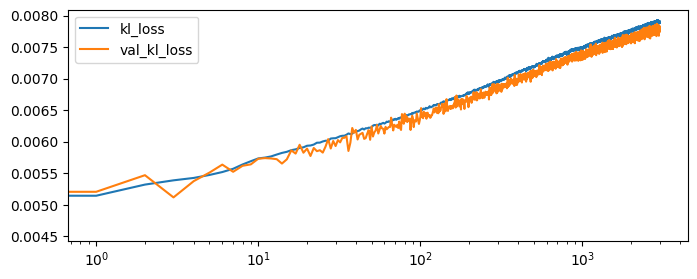

In [ ]:
dense2_cvae_train_results_pdf[["kl_loss","val_kl_loss"]].plot(figsize=(8,3), logx=True)
dense2_cvae_train_results_pdf[["loss","val_loss"]].plot(figsize=(8,3), logx=True)

## Dense CVAE 8dim

In [ ]:
%%time

# DENSE_CVAE =====================================================
dense_encoder_8d = create_dense_encoder_2(8, dropout_rate)
dense_decoder_8d = create_dense_decoder_2(8, dropout_rate)

dense_cvae_8d = CVAE(dense_encoder_8d, dense_decoder_8d, name="CVAE")
dense_cvae_8d.compile(optimizer=Adam(start_lr), run_eagerly=False)

dense_cvae_8d.build(input_shape=[(None, 28, 28, 1), (None, 10), (None, 10)])
# print(dense_cvae.summary())

# # Save for Netron visualisation
# dense2_cvae.encoder.save("../models/04_cvae_dense2_encoder_model.h5", save_format="h5")
# dense2_cvae.decoder.save("../models/04_cvae_dense2_decoder_model.h5", save_format="h5")

# Save weights -----------------------------------------------------
dense2_cvae.save_weights("../models/04_dense2_cvae_weights.h5")


# Train --------------------------------------------------------
dense_cvae_8d_train_results = dense_cvae_8d.fit(
        [x_train, y_train_cat, y_train_cat],
        x_train,
        shuffle=True,
        validation_data=([x_test, y_test_cat, y_test_cat], x_test),
        epochs=max_epochs,
        batch_size=batch_size,
        verbose=0,
    )

dense_cvae_8d_train_results_pdf = pd.DataFrame(
        dense_cvae_8d_train_results.history, index=dense_cvae_8d_train_results.epoch
    )

# epochs=4000 - 3h 42min

CPU times: total: 4h 43min 37s
Wall time: 3h 42min 40s


In [ ]:
print ("losses:" + "="*53)
print("dense_cvae_8d:\n", dense_cvae_8d_train_results_pdf.tail(1).to_string(index=False, header=True, line_width=None))

losses:=====================================================
dense_cvae_8d:
     loss  reconstruction_loss  kl_loss  val_loss  val_reconstruction_loss  val_kl_loss
0.117094             0.098244  0.01885  0.123946                  0.10547     0.018663


<AxesSubplot:>

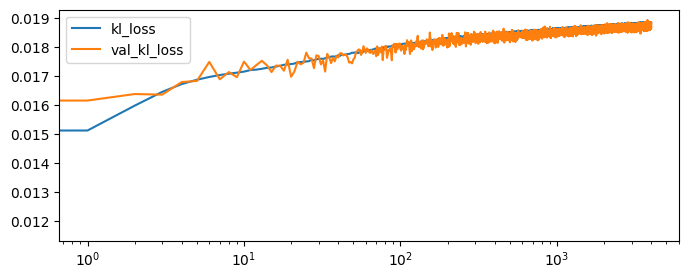

In [ ]:
dense_cvae_8d_train_results_pdf[["kl_loss","val_kl_loss"]].plot(figsize=(8,3), logx=True)
dense_cvae_8d_train_results_pdf[["loss","val_loss"]].plot(figsize=(8,3), logx=True)

## Результаты

Переводит цифры этот автоэнкодер вот так:
![](./figs4/map.png)

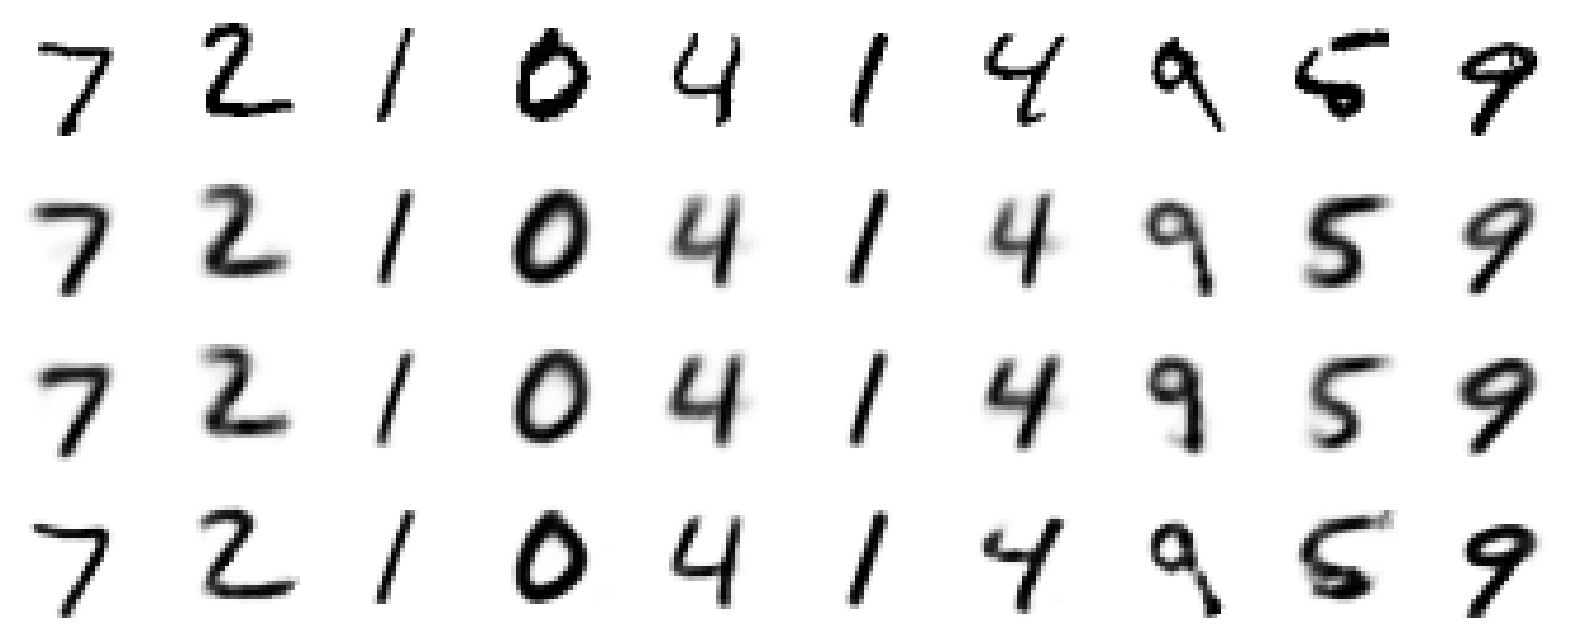

In [ ]:
input_images = x_test[:10]
dense_images = dense_cvae.predict([x_test[:10], y_test_cat[:10], y_test_cat[:10]], verbose = 0)
dense2_images = dense2_cvae.predict([x_test[:10], y_test_cat[:10], y_test_cat[:10]], verbose = 0)
dense8d_images = dense_cvae_8d.predict([x_test[:10], y_test_cat[:10], y_test_cat[:10]], verbose = 0)

plot_digits(input_images, dense_images, dense2_images, dense8d_images);

### Перенос стиля этой моделью

В качестве источником стиля возьмем первые 10 нулей, и на основе их кода $Z$ создадим остальные цифры.


In [ ]:
def style_transfer(model:CVAE, X:np.array, lbl_in:Union[int], lbl_out):
    """Applies style transfer to given inputs.

    Parameters
    ----------
    model : object
        The model to be used for style transfer.
    X : numpy.ndarray
        The input images with shape `(rows, height, width, channels)`.
    lbl_in : int or numpy.ndarray
        If `lbl_in` is an int, it will be converted to a one-hot encoded array with shape `(rows, 10)`.
        If `lbl_in` is already a one-hot encoded array, it should have shape `(rows, 10)`.
    lbl_out : int or numpy.ndarray
        If `lbl_out` is an int, it will be converted to a one-hot encoded array with shape `(rows, 10)`.
        If `lbl_out` is already a one-hot encoded array, it should have shape `(rows, 10)`.

    Returns
    -------
    numpy.ndarray
        The result of the style transfer with shape `(rows, height, width, channels)`.

    """
    rows = X.shape[0]
    if isinstance(lbl_in, int):
        lbl = lbl_in
        lbl_in = np.zeros((rows, 10))
        lbl_in[:, lbl] = 1
    if isinstance(lbl_out, int):
        lbl = lbl_out
        lbl_out = np.zeros((rows, 10))
        lbl_out[:, lbl] = 1
    return model.predict([X, lbl_in, lbl_out], verbose = 0)


#### Dense cvae 2d

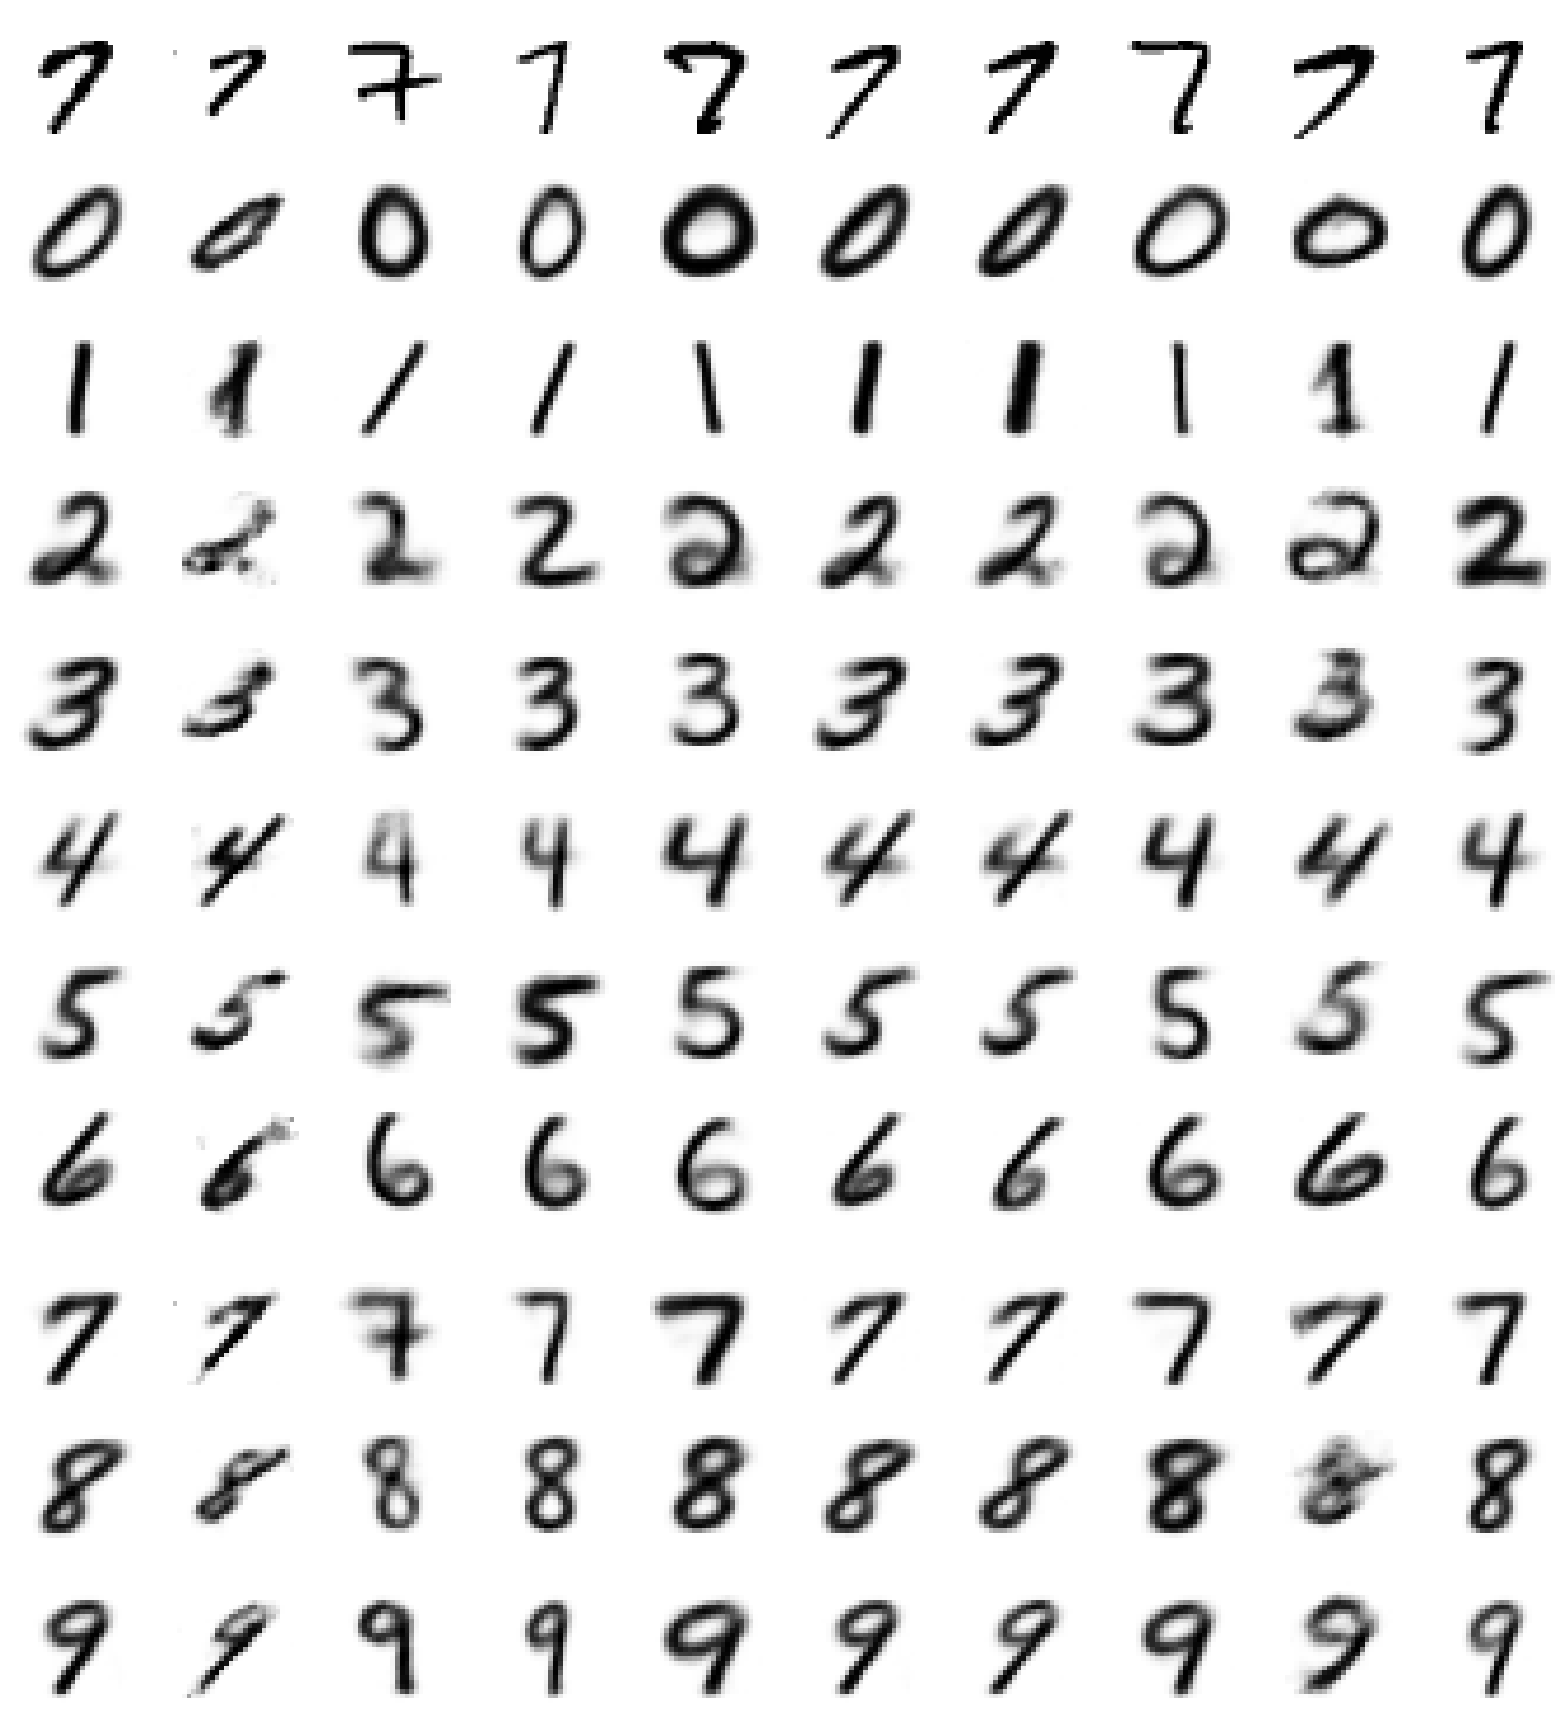

In [ ]:
n = 10  # кол-во цифр для эксперимента
lbl = 7 # базовое значение label, относительно которого будем переносить стили
generated = []
prot = x_train[y_train == lbl][:n]

for i in range(num_classes):
    generated.append(style_transfer(dense_cvae, prot, lbl, i))

plot_digits(prot, *generated, show=True);

#### Dense cvae 2d - 2

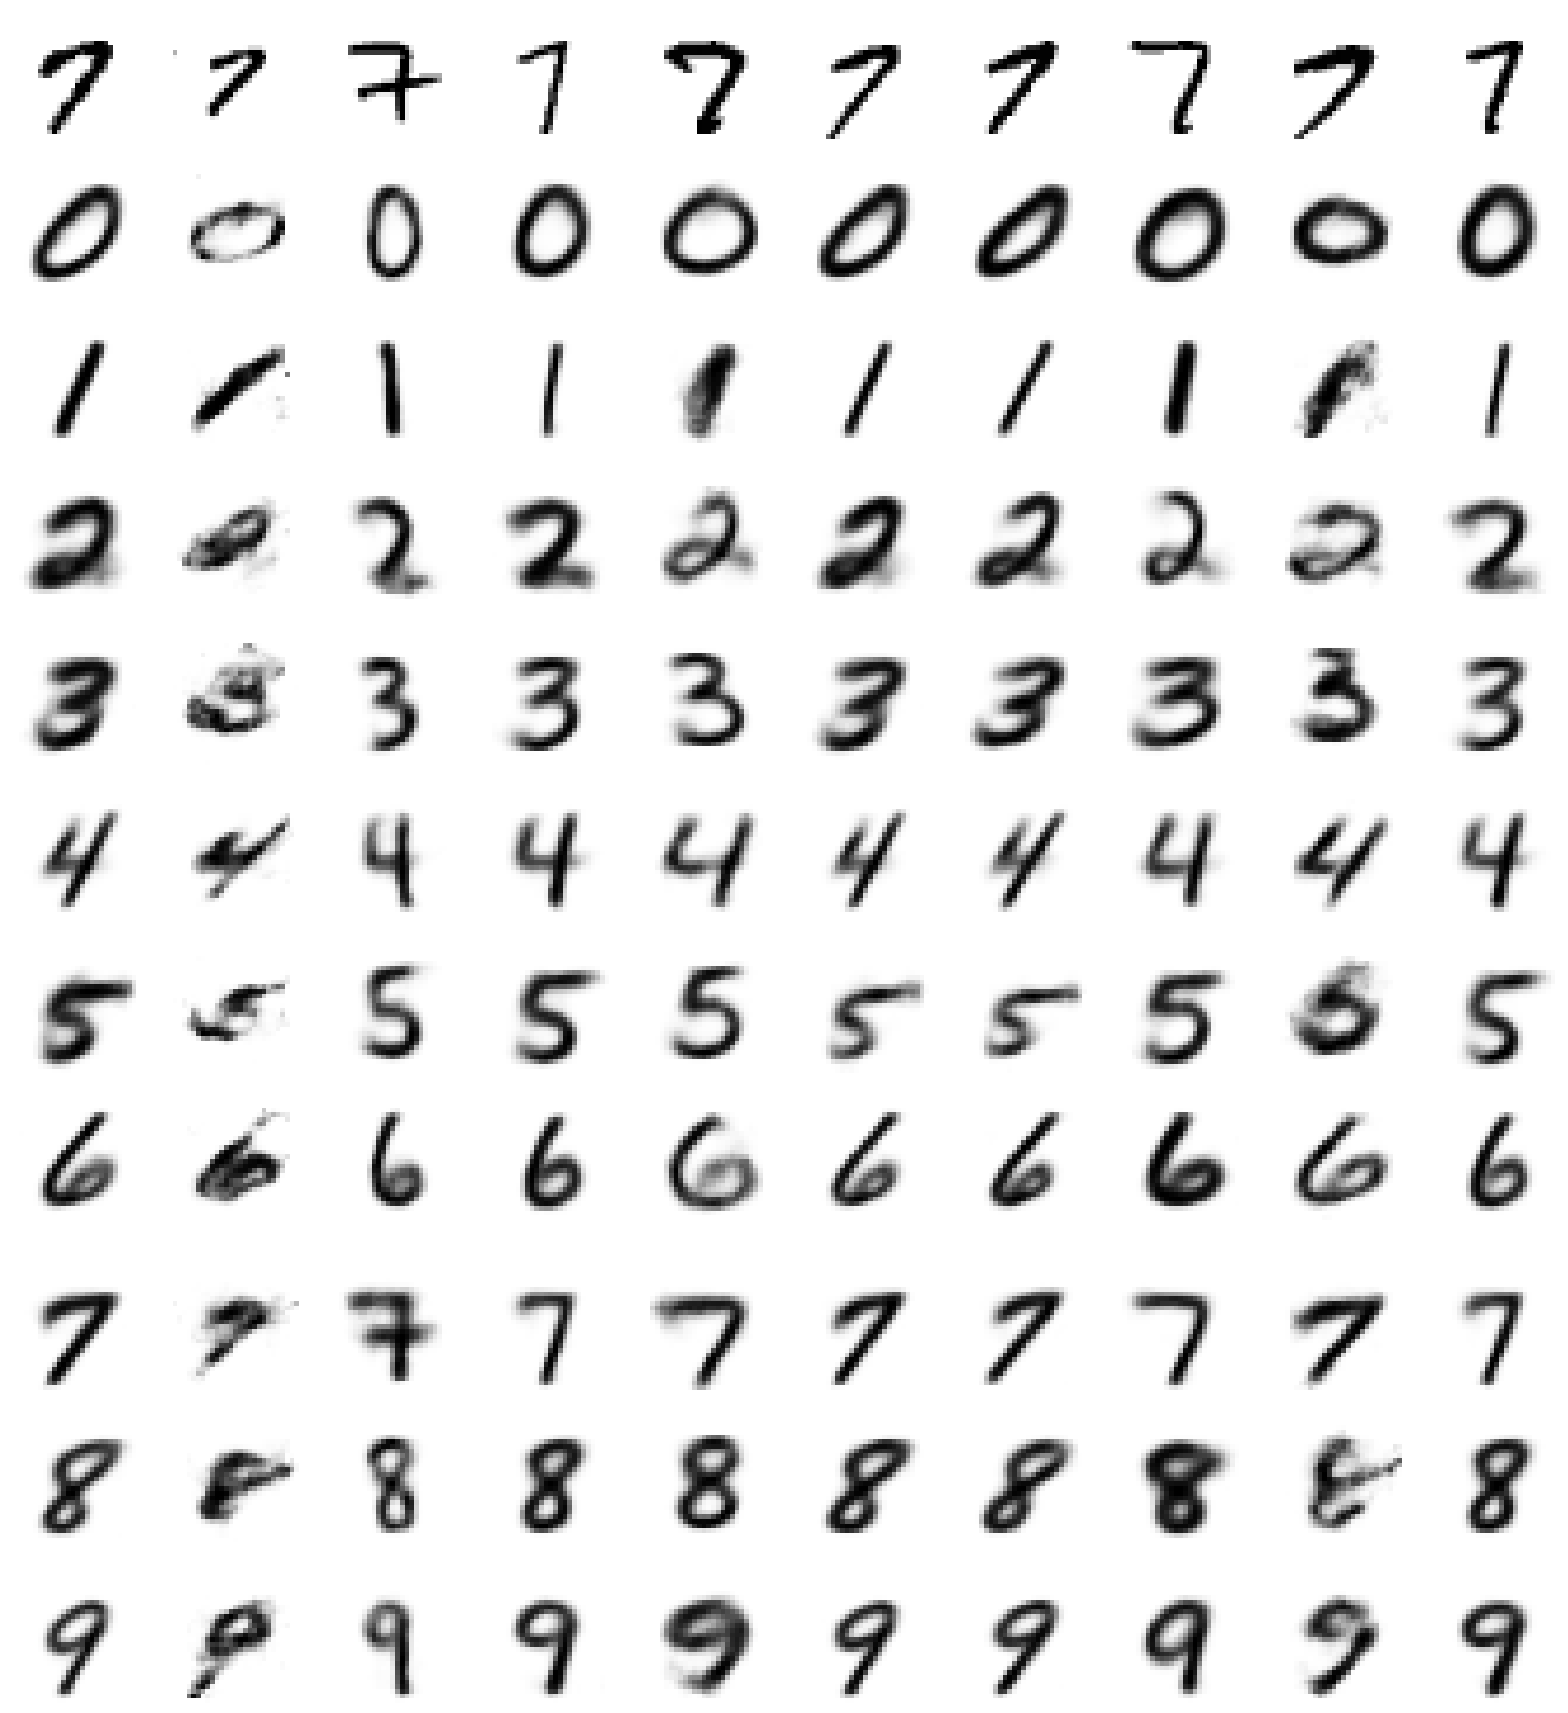

In [ ]:
n = 10  # кол-во цифр для эксперимента
lbl = 7 # базовое значение label, относительно которого будем переносить стили
generated = []
prot = x_train[y_train == lbl][:n]

for i in range(num_classes):
    generated.append(style_transfer(dense2_cvae, prot, lbl, i))

plot_digits(prot, *generated, show=True);

#### Dense cvae 8 dim



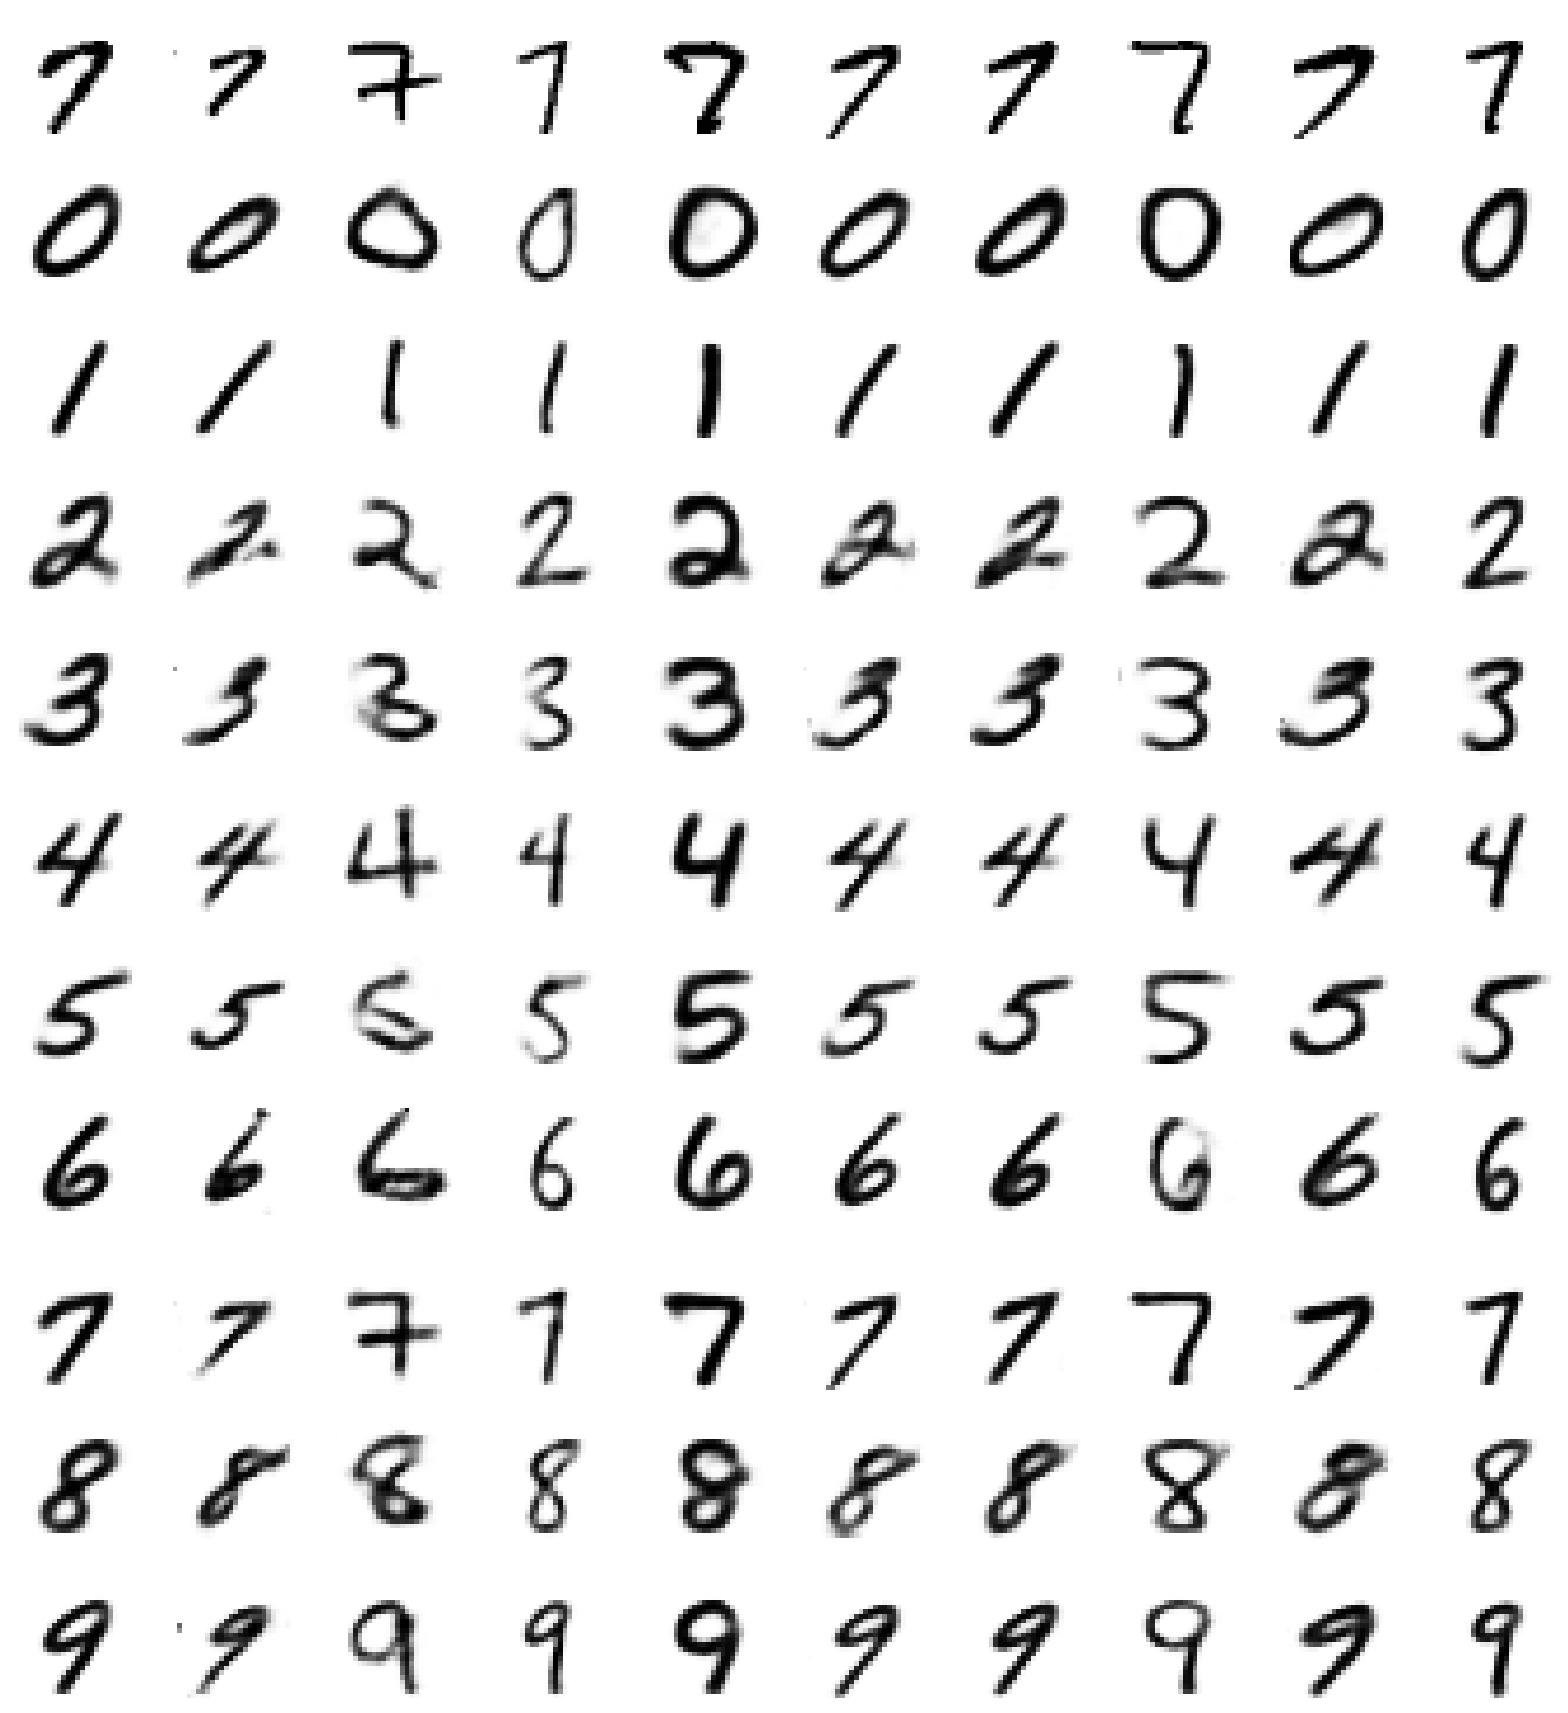

In [ ]:
n = 10  # кол-во цифр для эксперимента
lbl = 7 # базовое значение label, относительно которого будем переносить стили
generated = []
prot = x_train[y_train == lbl][:n]

for i in range(num_classes):
    generated.append(style_transfer(dense_cvae_8d, prot, lbl, i))

plot_digits(prot, *generated, show=True);

Стиль перенесен довольно удачно: сохранен наклон и толщина штриха.

Больше свойств стиля можно было бы переносить просто увеличив размерность $Z$, это также сделало бы цифры менее размытыми.

В следующей части посмотрим, как используя *генеративные состязающиеся сети (GAN)*, научить автоэнкодер генерировать изображения практически неотличимые от настоящих.

## DRAFTS

In [161]:


# learning -------------------------------------------------------
(
    dense_cvae_manifold_figs,
    dense_cvae_latent_distrs,
    dense_cvae_sample_imgs,
    dense_cvae_epochs,
    dense_cvae_train_results_pdf,
) = fit_and_collect_learning_history(
    dense_cvae, num_classes=num_classes, max_epochs=10, batch_size=batch_size
)


1/1 [==============================] - 0s 20ms/step


In [20]:
len(dense2_cvae_manifold_figs[5])

65

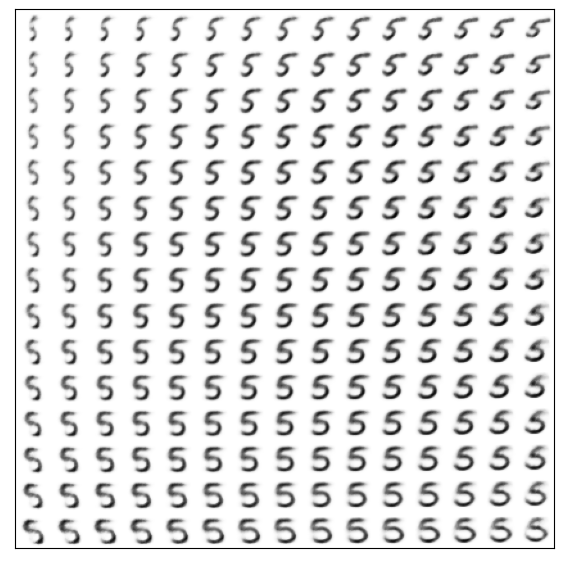

In [18]:
# dense_cvae_manifold_figs[5][9]


dense2_cvae_manifold_figs[5][9]


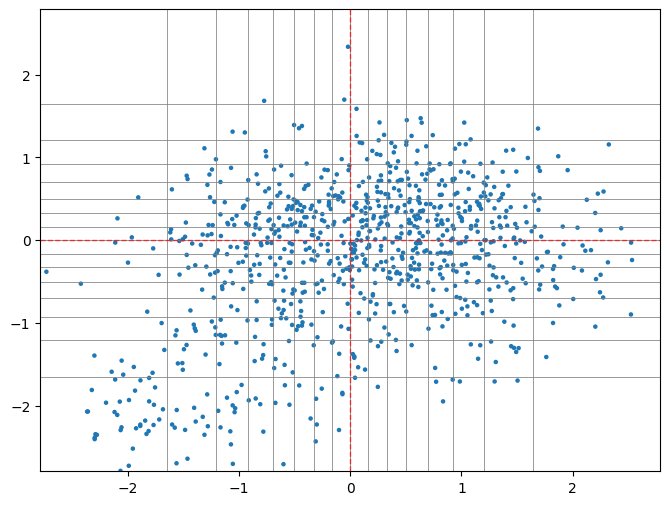

In [170]:
dense_cvae_latent_distrs[5][9]

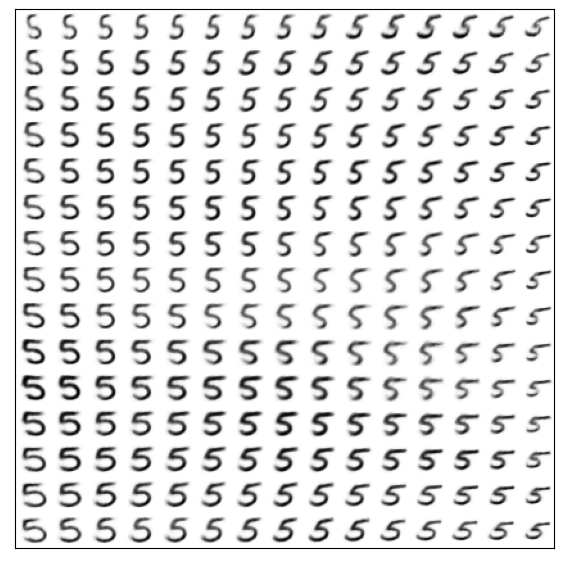

In [258]:
dense_cvae_manifold_figs[5][50]

In [217]:
axs.reshape(-1)[0].imshow(arr2)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

In [231]:
len(dense_cvae_epochs)

65

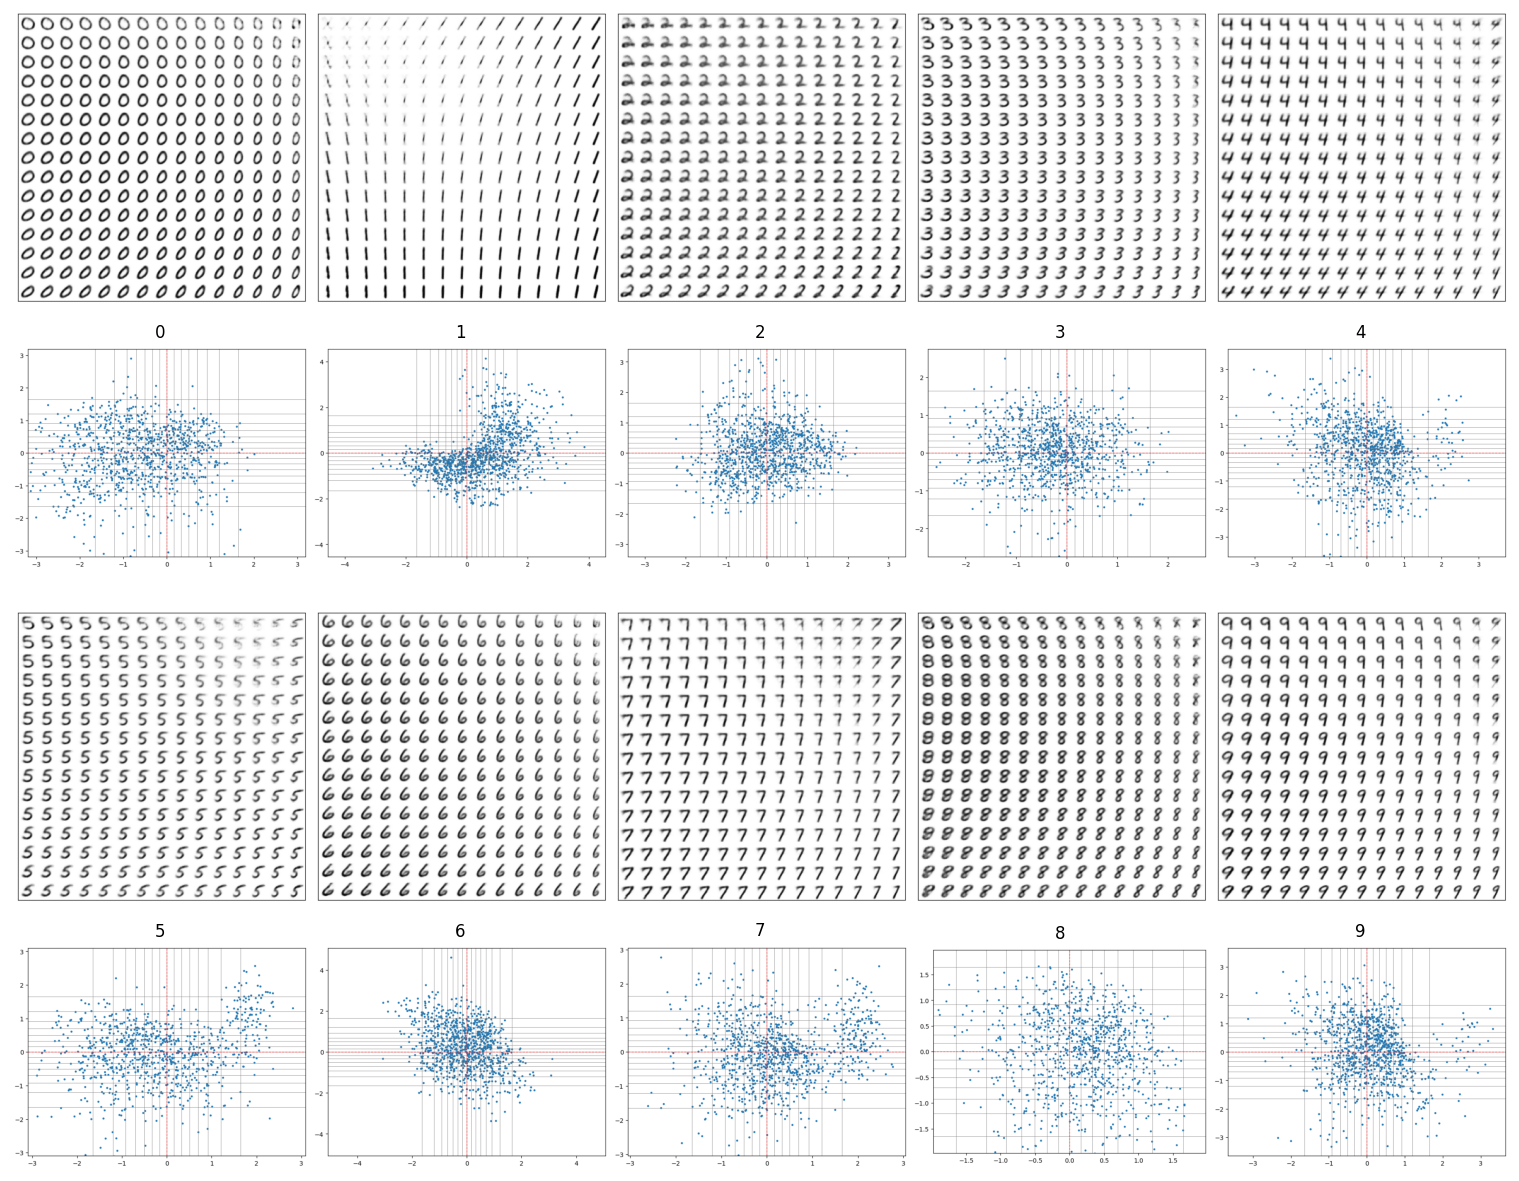

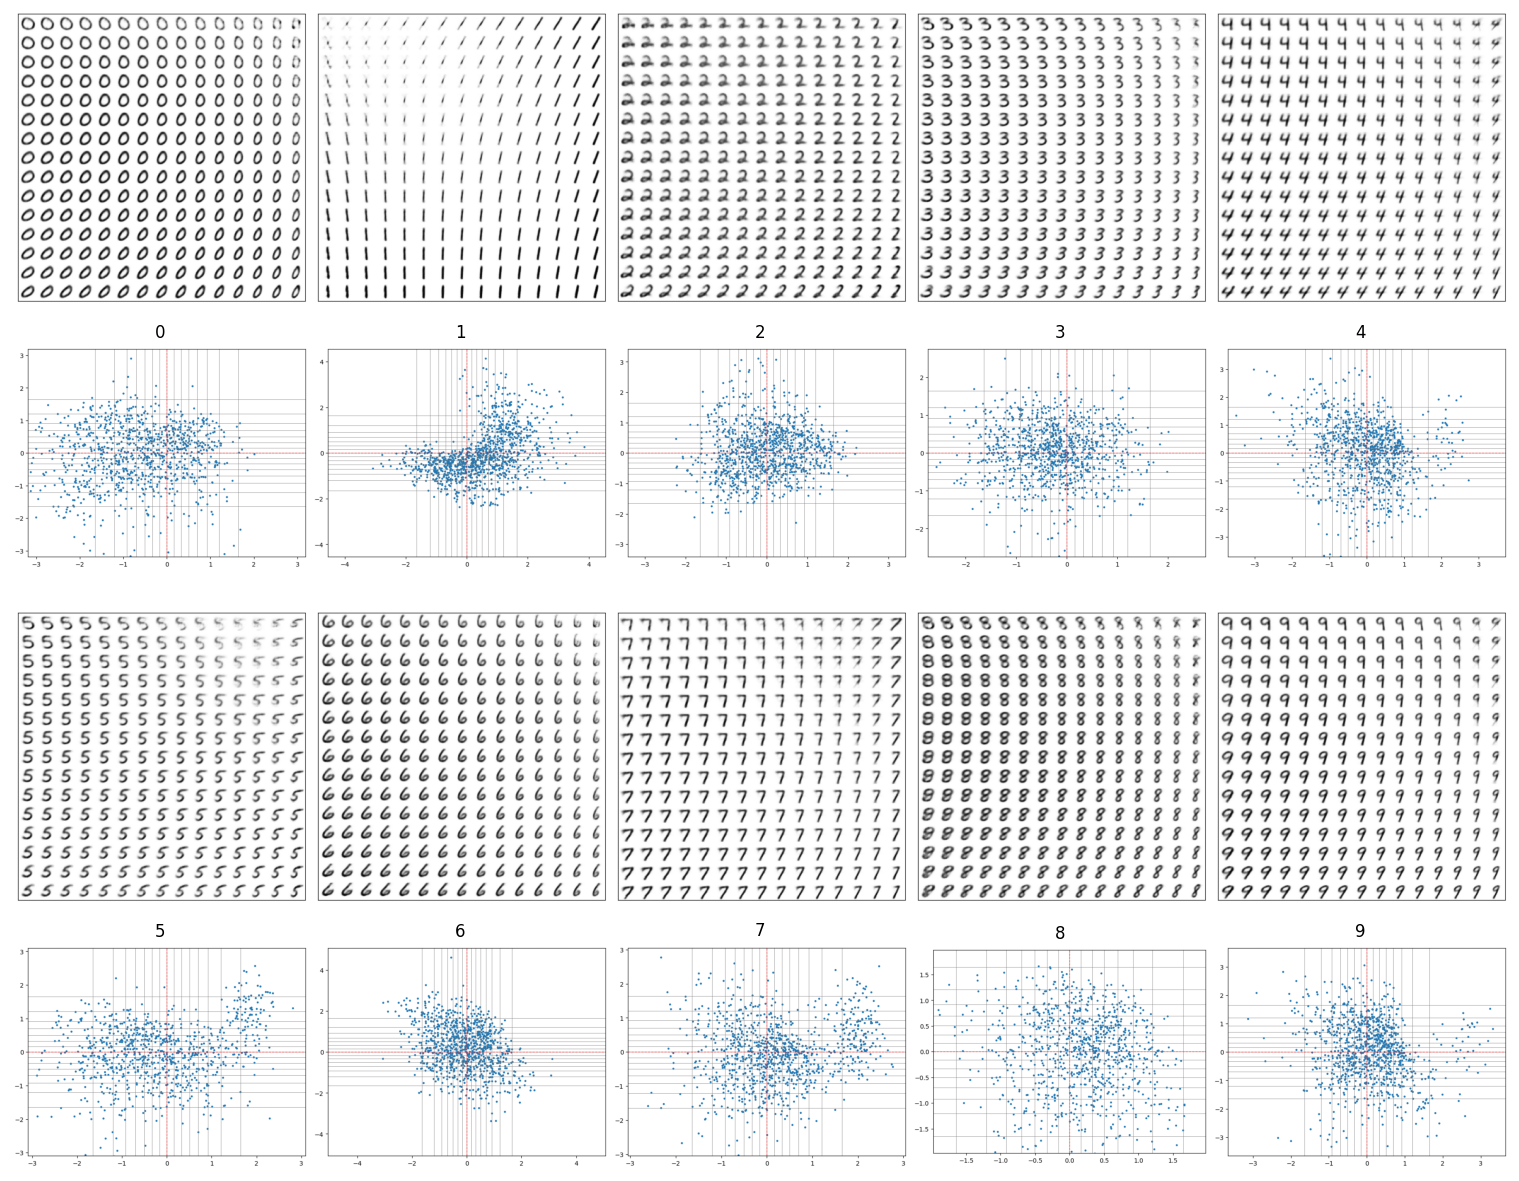

In [33]:
epoch_id = 9

# for lbl in range(10):
#     print(lbl)

def prepare_figures_list(
        manifold_figs_list,
        latent_distrs_figs_list,
    epoch_id: int, figsize: Tuple[int, int] = (15, 12), show: bool = True
) -> mpl.figure.Figure:
    
    fig, axs = plt.subplots(4, 5, figsize=figsize)

    for i in range(10):
        lbl = i

        id = (i if i<5 else i+5)

        # manifold image
        image_array = convert_figures_to_array(manifold_figs_list[lbl][epoch_id])
        ax = axs.reshape(-1)[id]
        ax.axis("off")
        ax.imshow(image_array)

        # latent distr image
        image_array = convert_figures_to_array(latent_distrs_figs_list[lbl][epoch_id])
        ax = axs.reshape(-1)[id + 5]
        ax.axis("off")
        ax.set_title(lbl)
        ax.imshow(image_array)

    plt.tight_layout(pad=0, h_pad=0, w_pad=0)

    if show:
        plt.show()
    else:
        plt.close()
    return fig



prepare_figures_list(
manifold_figs_list = dense_cvae_manifold_figs,
latent_distrs_figs_list = dense_cvae_latent_distrs,
epoch_id = 9,
figsize = (15,12),
show = True,
)

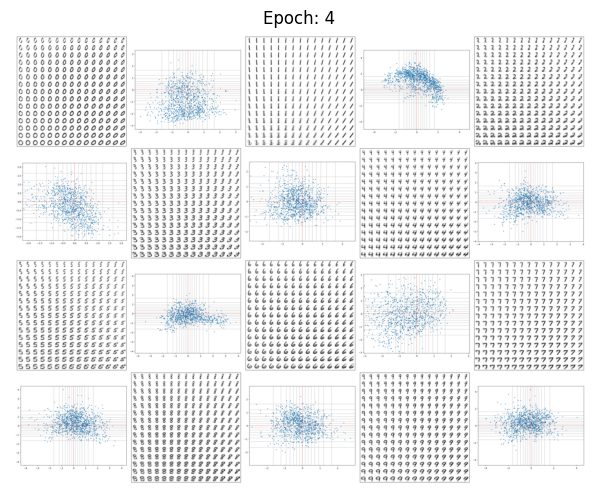

In [251]:
#  ===================================================================
max_frame = 5
epoch_list = dense_cvae_epochs[:5]
figures_list = figures_list[:5]


# figures_list = [prepare_figures_list(
# manifold_figs_list = dense_cvae_manifold_figs,
# latent_distrs_figs_list = dense_cvae_latent_distrs,
# epoch_id = epoch_id,
# figsize=(15,12),
# show=False,
# ) for epoch_id in range(len(epoch_list))]

titles_list = [f"Epoch: {e}" for e in epoch_list]

figsize = (10,7)


# create animation
filename = "test.mp4"

if 1==1:

    def update(frame):
        plt.clf()  # Clear the previous plot
        arr1 = convert_figures_to_array(figures_list[frame])
        # Recreate the plot with new data
        plt.imshow(arr1)
        plt.axis("off")
        plt.title(str(titles_list[frame]))
        plt.tight_layout(pad=0, h_pad=0, w_pad=0)

    if figsize is not None:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure()

    # canvas = mpl.backends.backend_agg.FigureCanvasAgg(fig)
    # Create the animation
    ani = animation.FuncAnimation(
        fig, update, frames=range(len(figures_list)), interval=250
    )

    # Save the animation as an MP4 file
    if filename is not None:
        # writer = animation.FFMpegWriter(fps=4, bitrate=1800)
        writer = animation.FFMpegWriter(fps=4, bitrate=500)
        ani.save(filename, writer=writer)

    plt.close(fig)
    # return ani

# plt.show()

display(HTML(ani.to_html5_video()))


65


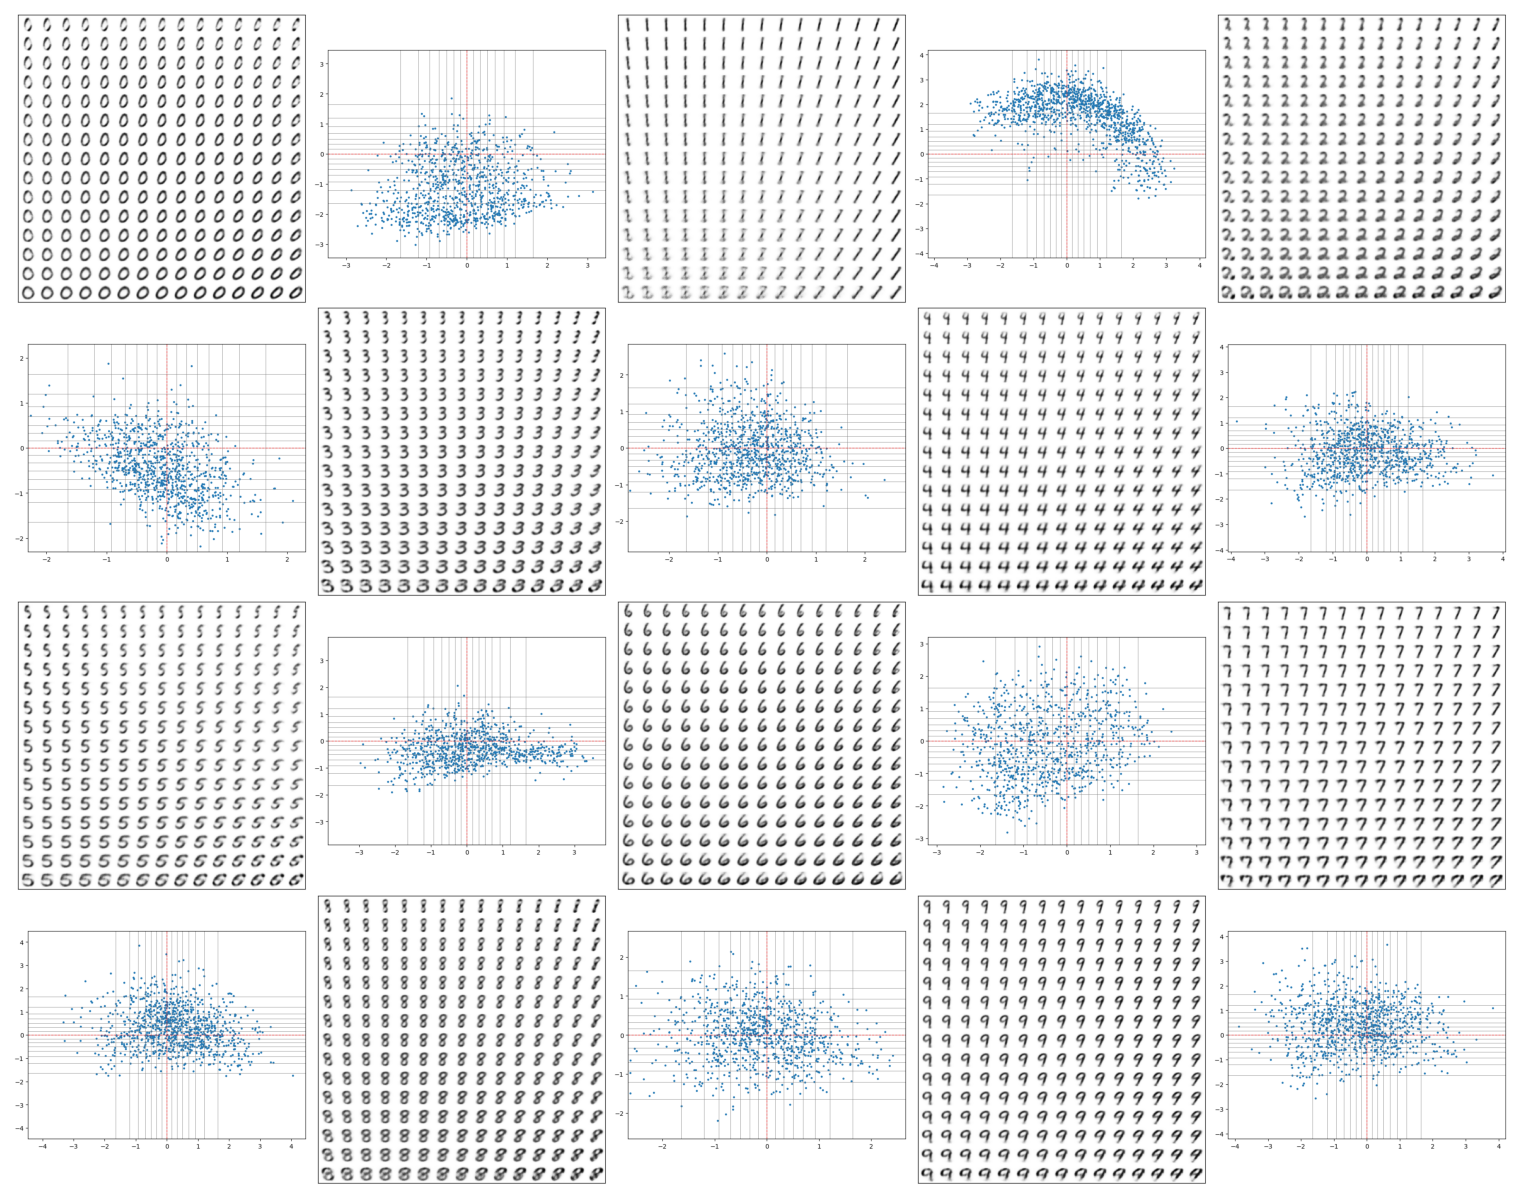

In [237]:
print(len(figures_list))
figures_list[2]

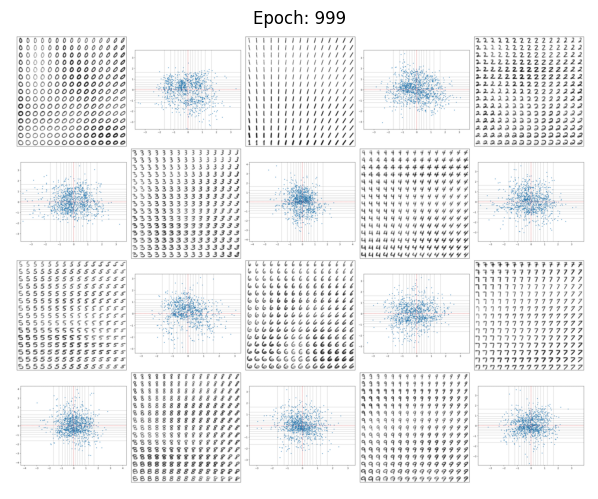

In [235]:
filename = "test.mp4"

if filename is not None:
        # writer = animation.FFMpegWriter(fps=4, bitrate=1800)
        writer = animation.FFMpegWriter(fps=4, bitrate=500)
        ani.save(filename, writer=writer)

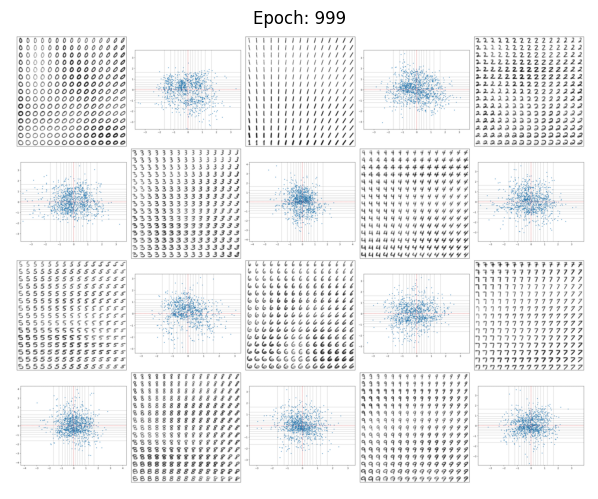

In [233]:
# display(HTML(ani.to_html5_video()))


1/1 [==============================] - 0s 20ms/step


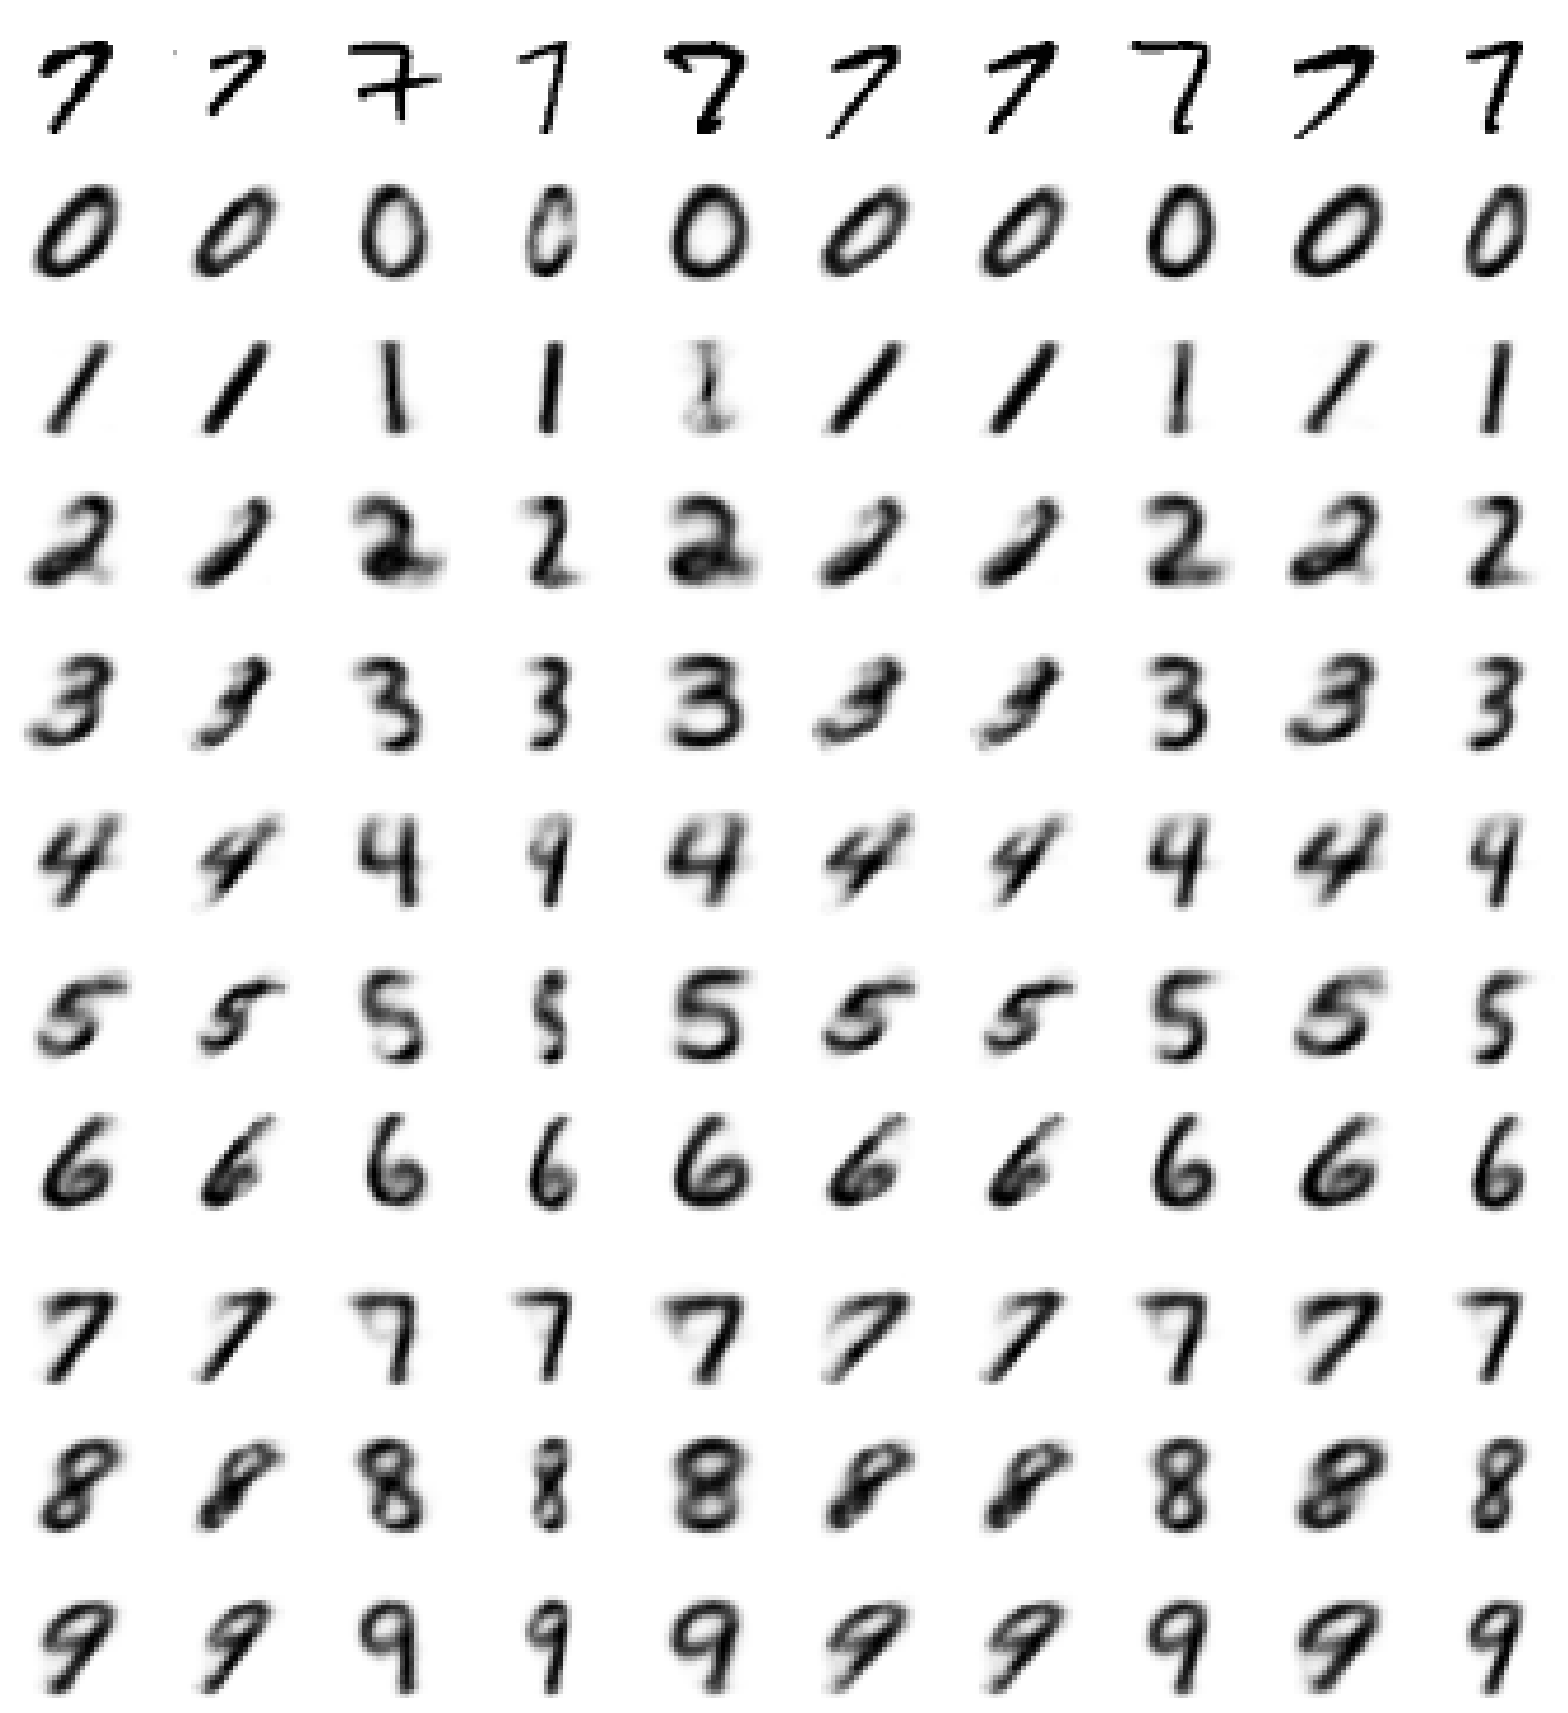

In [190]:
# y_test_cat[1:2]


def style_transfer(model, X, lbl_in, lbl_out):
    rows = X.shape[0]
    if isinstance(lbl_in, int):
        lbl = lbl_in
        lbl_in = np.zeros((rows, 10))
        lbl_in[:, lbl] = 1
    if isinstance(lbl_out, int):
        lbl = lbl_out
        lbl_out = np.zeros((rows, 10))
        lbl_out[:, lbl] = 1
    return model.predict([X, lbl_in, lbl_out])



n = 10
lbl = 7
generated = []
prot = x_train[y_train == lbl][:n]

for i in range(num_classes):
    generated.append(style_transfer(dense_cvae, prot, lbl, i))

# generated[lbl] = prot

plot_digits(prot, *generated, show=True);